In this notebook, we explore the application of Directed Acyclic Graph (DAG)-based Graph Neural Networks (GNNs) to learn a diffusion model over a DAG structure. The objective is to test whether different an architectures are capable of predicting the output signals given some sparse inputs. Leveraging the inherent structure of the DAG will play a fundamental role in the performance of the considered architectures.

We investigate various settings to understand their impact on the diffusion process and prediction accuracy. These settings include:
- The number of DAG-based Graph Signal Operators (GSOs) involved in the diffusion process.
- The number of seeding nodes (sources) from which the diffusion starts.
- The influence of selecting different transitive closures on the diffusion process.

By experimenting with these settings, we aim to gain insights into how different configurations affect the performance and efficiency of the diffusion model. Ultimately, our goal is to develop an optimized architecture that can effectively capture and utilize the underlying structure of the DAG for accurate predictions.

In [1]:
import numpy as np
from numpy import linalg as la
import networkx as nx
import matplotlib.pyplot as plt
import time
import dgl
import torch
from torch import nn
from torch.nn import functional as F

import src.dag_utils as dagu
import src.utils as utils
from src.arch import DAGConv, FB_DAGConv, SF_DAGConv
from src.models import Model
from src.baselines_archs import GCNN_2L, GCNN, GAT, MLP

# Ser random seed
SEED = 10
PATH = 'results/diffusion/'
SAVE = True
np.random.seed(SEED)
torch.manual_seed(SEED)
dgl.random.seed(SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
device_count = torch.cuda.device_count()
print("Number of CUDA devices available:", device_count)

# Get the name of each CUDA device
for i in range(device_count):
    device_name = torch.cuda.get_device_name(i)
    device_properties = torch.cuda.get_device_properties(i)
    total_memory_gb = device_properties.total_memory / (1024 ** 3)  # Convert bytes to gigabytes
    print(f"Properties of CUDA device {i} ({device_name}):")
    print("Total Memory:", device_properties.total_memory, "in GB:", total_memory_gb)
    print("CUDA Capability:", device_properties.major, ".", device_properties.minor)


Number of CUDA devices available: 1
Properties of CUDA device 0 (Quadro RTX 8000):
Total Memory: 50951487488 in GB: 47.4522705078125
CUDA Capability: 7 . 5


## Initial test

In [3]:
M = 2000

data_p = {
    'n_tries': 25,

    ## Graph parameters
    'p': 0.2,                    # Edge prob in Erdos-Renyi DAG
    'N': 100,                    # Number of nodes

    ## Signal parameters
    'M': M,                   # Number of observed signals
    'M_train': int(0.7 * M),  # Samples selected for training
    'M_val': int(0.2 * M),    # Samples selected for validation
    'M_test': int(0.1 * M),   # Samples selected for test
    'src_t': 'constant',          # 'random' or 'constant'
    'max_src_node': 15,           # Maximum index of nodes allowed to be sources
    'n_sources': 5,              # Maximum Number of source nodes
    'n_p': 0.05,                 # Normalized noise power
    'max_GSO': 100,              # Maximum index of GSOs involved in the diffusion
    'min_GSO': 50,               # Minimum index of GSOs involved in the diffusion
    'n_GSOs': 25                 # Number of GSOs
}

# Model parameters
default_arch_p = {
    'in_dim': 1,        # Input dimension
    'hid_dim': 64,     # Hidden dimension
    'out_dim': 1,       # Output dimension
    'L': 2,  # 3 also works well          # Number of layers
}

default_mod_p = {
    'bs': 25,           # Size of the batch
    'lr': 5e-4,         # Learning rate
    'epochs': 50,       # Number of training epochs 
    'pat': 15,          # Number of non-decreasing epoch to stop training
    'wd': 1e-4,         # Weight decay
}

In [4]:
def get_graph_data(d_dat_p):
    Adj, dag = dagu.create_dag(d_dat_p['N'], d_dat_p['p'])
    W = la.inv(np.eye(d_dat_p['N']) - Adj)
    W_inf = la.inv(W)
    GSOs = np.array([(W * dagu.compute_Dq(dag, i, d_dat_p['N'])) @ W_inf for i in range(d_dat_p['N'])])
    return Adj, W, GSOs

def get_signals(d_p, GSOs):
    range_GSO = np.arange(d_p['min_GSO'], d_p['max_GSO'])
    gsos_idx = np.random.choice(range_GSO, size=d_p['n_GSOs'], replace=False)
    sel_GSOs = GSOs[gsos_idx]
    Y_t, X_t = dagu.create_diff_data(d_p['M'], sel_GSOs, d_p['max_src_node'], d_p['n_p'],
                                         d_p['n_sources'], src_t=d_p['src_t'], torch_tensor=True)
                
    X_data = {'train': X_t[:d_p['M_train']], 'val': X_t[d_p['M_train']:-d_p['M_test']], 'test': X_t[-d_p['M_test']:]}
    Y_data = {'train': Y_t[:d_p['M_train']], 'val': Y_t[d_p['M_train']:-d_p['M_test']], 'test': Y_t[-d_p['M_test']:]}
    return X_data, Y_data, sel_GSOs

def run_exps(exps, d_arc_p, d_mod_p, d_dat_p, GSOs, W, Adj, exp_desc='default'):
    err_exps = np.zeros(len(exps))
    std_exps = np.zeros(len(exps))
    times_exps = np.zeros(len(exps))
    for k, exp in enumerate(exps):
        arc_p = {**d_arc_p, **exp['arc_p']}
        mod_p = {**d_mod_p, **exp['mod_p']} if 'mod_p' in exp else d_mod_p
        d_p = {**d_dat_p, **exp['dat_p']} if 'dat_p' in exp else d_dat_p

        X_data, Y_data, sel_GSOs = get_signals(d_p, GSOs)
        GSO = utils.select_GSO(arc_p, GSOs, sel_GSOs, W, Adj)
        K = GSO.shape[0] if isinstance(GSO, torch.Tensor) and len(GSO.shape) == 3 else 0  
        arch = utils.instantiate_arch(arc_p, K)
        model = Model(arch, device=device)

        t_i = time.time()
        model.fit(X_data, Y_data, GSO, mod_p['lr'], mod_p['epochs'], mod_p['bs'], mod_p['wd'],
                  patience=mod_p['pat'])
        t_e = time.time() - t_i

        err_exps[k], std_exps[k] = model.test(X_data['test'], Y_data['test'], GSO)
        times_exps[k] = t_e
        print(f'\t-{exp_desc}. {exp["leg"]}: err: {err_exps[k]:.3f} - time: {times_exps[k]:.1f}')

    return err_exps, std_exps, times_exps

def run_exp(d_p, d_arc_p, d_mod_p, exps):
    err = np.zeros((d_p['n_tries'], len(exps)))
    std = np.zeros((d_p['n_tries'], len(exps)))
    times = np.zeros((d_p['n_tries'], len(exps)))
    t_begin = time.time()

    for i in range(d_p['n_tries']):
        Adj, W, GSOs = get_graph_data(d_p)
        X_data, Y_data, sel_GSOs = get_signals(d_p, GSOs)
        
        for j, exp in enumerate(exps):
            arc_p = {**d_arc_p, **exp['arc_p']}
            mod_p = {**d_mod_p, **exp['mod_p']}

            GSO = utils.select_GSO(arc_p, GSOs, sel_GSOs, W, Adj)

            K = GSO.shape[0] if isinstance(GSO, torch.Tensor) and len(GSO.shape) == 3 else 0  
            arch = utils.instantiate_arch(arc_p, K)
            model = Model(arch, device=device)

            t_i = time.time()
            model.fit(X_data, Y_data, GSO, mod_p['lr'], mod_p['epochs'], mod_p['bs'], mod_p['wd'],
                      patience=mod_p['pat'])
            t_e = time.time() - t_i

            err[i,j], std[i,j] = model.test(X_data['test'], Y_data['test'], GSO)
            times[i,j] = t_e

            print(f'-{i}. {exp["leg"]}: err: {err[i,j]:.3f} - time: {times[i,j]:.1f}')

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return err, std, times

In [11]:
# Experiments to be run
Exps = [
    {'arc_p': {'arch': DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'DAGCNN'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'sel_GSOs'}, 'mod_p': {}, 'leg': 'DAGCNN-Prior'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5}, 'mod_p': {}, 'leg': 'DAGCNN-Rnd'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'FB-DAGCNN'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs'}, 'mod_p': {}, 'leg': 'FB-DAGCNN-Prior'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5}, 'mod_p': {}, 'leg': 'FB-DAGCNN-Rnd'},

    {'arc_p': {'arch': GCNN_2L, 'GSO': 'A'}, 'mod_p': {}, 'leg': 'GNN-A'},
    {'arc_p': {'arch': GCNN_2L, 'GSO': 'W'}, 'mod_p': {}, 'leg': 'GNN-W'},
    # {'arc_p': {'arch': GAT, 'GSO': 'A', 'n_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}},
    #  'mod_p': {}, 'leg': 'GAT-A'},
    # {'arc_p': {'arch': GAT, 'GSO': 'W', 'n_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}},
    #  'mod_p': {}, 'leg': 'GAT-W'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'mod_p': {}, 'leg': 'MLP'},
    ]

err, std, times = run_exp(data_p, default_arch_p, default_mod_p, Exps)

False
torch.Size([100, 100, 100])


-0. DAGCNN: err: 4.191 - time: 0.5
False
torch.Size([25, 100, 100])
-0. DAGCNN-Prior: err: 0.630 - time: 0.1
False
torch.Size([5, 100, 100])
-0. DAGCNN-Rnd: err: 1.111 - time: 0.1
False
torch.Size([100, 100, 100])
-0. FB-DAGCNN: err: 0.046 - time: 0.4
False
torch.Size([25, 100, 100])
-0. FB-DAGCNN-Prior: err: 0.042 - time: 0.1
False
torch.Size([5, 100, 100])
-0. FB-DAGCNN-Rnd: err: 0.111 - time: 0.1
False


AttributeError: 'DGLGraph' object has no attribute 'shape'

In [ ]:
if SAVE:
    file_name = PATH + f'init_exp-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times)

leg = [exp['leg'] for exp in Exps]
utils.display_data(leg, err, std, times)

,Exp,Mean Err,Median Err,Mean Std,time
0,DAGCNN,1.498243,1.498243,0.188561,0.824718
1,DAGCNN-Prior,0.161804,0.161804,0.030107,0.143703
2,DAGCNN-Rnd,0.715624,0.715624,0.027610,0.116873
3,FB-DAGCNN,0.023921,0.023921,0.013853,0.422978
4,FB-DAGCNN-Prior,0.024115,0.024115,0.012486,0.124813
5,FB-DAGCNN-Rnd,0.077543,0.077543,0.030615,0.092262
6,GNN-A,0.885319,0.885319,0.016946,0.515800
7,GNN-W,0.902662,0.902662,0.016959,0.289236
8,MLP,1.327080,1.327080,0.022087,0.048090


## Influence of selected GSOs

In [ ]:
def influence_gso_exp(d_dat_p, d_arc_p, d_mod_p, N_GSOs, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    t_begin = time.time()

    for i in range(d_dat_p['n_tries']):
        print('Iteration:', i)

        Adj, W, GSOs = get_graph_data(d_dat_p)

        for j, n_gsos in enumerate(N_GSOs):
            data_params_aux = dict(d_dat_p)
            data_params_aux['n_GSOs'] = n_gsos
            err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W, Adj)

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return err, std, times


In [ ]:
Exps = [
    {'dat_p': {'min_GSO': 0, 'max_GSO': 100}, 'arc_p': {'arch': DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'DAGCNN, All', 'fmt': 'v-'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 100}, 'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5},
     'mod_p': {}, 'leg': 'DAGCNN-Rnd, All', 'fmt': '^-'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'FB-DAGCNN, All', 'fmt': 'o-'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5},
     'mod_p': {}, 'leg': 'FB-DAGCNN-Rnd, All', 'fmt': 's-'},

    {'dat_p': {'min_GSO': 0, 'max_GSO': 50}, 'arc_p': {'arch': DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'DAGCNN, Firsts', 'fmt': 'v--'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 50}, 'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5}, 'mod_p': {}, 
     'leg': 'DAGCNN-Rnd, Firsts', 'fmt': '^--'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 50}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'FB-DAGCNN, Firsts', 'fmt': 'o--'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 50}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5},
     'mod_p': {}, 'leg': 'FB-DAGCNN-Rnd, Firsts', 'fmt': 's--'},

    {'dat_p': {'min_GSO': 50, 'max_GSO': 100}, 'arc_p': {'arch': DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'DAGCNN, Lasts', 'fmt': 'v:'},
    {'dat_p': {'min_GSO': 50, 'max_GSO': 100}, 'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5}, 'mod_p': {}, 
     'leg': 'DAGCNN-Rnd, Lasts', 'fmt': '^:'},
    {'dat_p': {'min_GSO': 50, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'FB-DAGCNN, Lasts', 'fmt': 'o:'},
    {'dat_p': {'min_GSO': 50, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs'}, 'mod_p': {},
     'leg': 'FB-DAGCNN-Rnd, Lasts', 'fmt': 's:'},
    ]

N_GSOs = np.arange(5, 41, 5)

err, std, times = influence_gso_exp(data_p, default_arch_p, default_mod_p, N_GSOs, Exps)

Iteration: 0


	-default. DAGCNN, All: err: 2.568 - time: 0.5
	-default. DAGCNN-Rnd, All: err: 0.042 - time: 0.1
	-default. FB-DAGCNN, All: err: 0.062 - time: 0.4
	-default. FB-DAGCNN-Rnd, All: err: 0.204 - time: 0.1
	-default. DAGCNN, Firsts: err: 0.677 - time: 0.5
	-default. DAGCNN-Rnd, Firsts: err: 0.894 - time: 0.1
	-default. FB-DAGCNN, Firsts: err: 0.118 - time: 0.4
	-default. FB-DAGCNN-Rnd, Firsts: err: 0.333 - time: 0.1
	-default. DAGCNN, Lasts: err: 0.151 - time: 0.5
	-default. DAGCNN-Rnd, Lasts: err: 0.104 - time: 0.1
	-default. FB-DAGCNN, Lasts: err: 0.031 - time: 0.4
	-default. FB-DAGCNN-Rnd, Lasts: err: 0.050 - time: 0.1
	-default. DAGCNN, All: err: 30.745 - time: 0.5
	-default. DAGCNN-Rnd, All: err: 0.163 - time: 0.1
	-default. FB-DAGCNN, All: err: 0.061 - time: 0.4
	-default. FB-DAGCNN-Rnd, All: err: 0.164 - time: 0.1
	-default. DAGCNN, Firsts: err: 0.435 - time: 0.5
	-default. DAGCNN-Rnd, Firsts: err: 0.618 - time: 0.1
	-default. FB-DAGCNN, Firsts: err: 0.108 - time: 0.4
	-default. FB-

In [ ]:
# # ### LOAD
# # file_name = PATH + 'gso_inf-constant.npz'
# # data = np.load(file_name)
# # err = data['err']
# # std = data['std']
# # times = data['times']
# # # data = np.load(file_name)

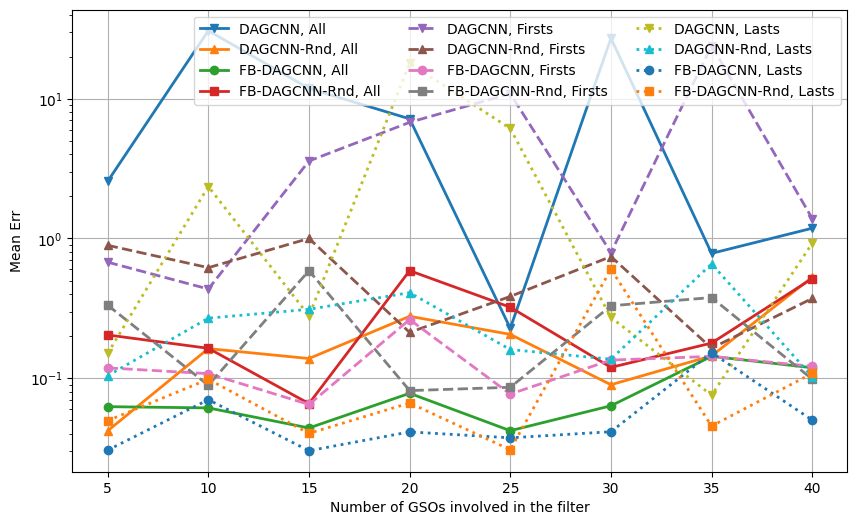

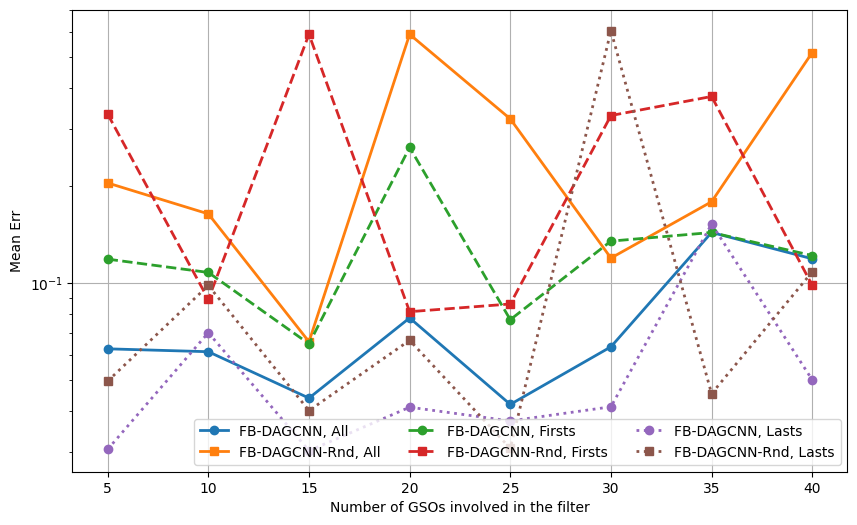

In [ ]:
if SAVE:
    file_name = PATH + f'gso_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_GSOs)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
med_err = np.median(err, axis=0)
utils.plot_results(med_err, N_GSOs, Exps, 'Number of GSOs involved in the filter')

skip_idx = [0, 1, 4, 5, 8, 9]
utils.plot_results(med_err, N_GSOs, Exps, 'Number of GSOs involved in the filter', skip_idx=skip_idx)

## Influence of the number of source nodes

In [ ]:
def influence_sources_exp(d_dat_p, d_arc_p, d_mod_p, N_sources, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_sources), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_sources), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_sources), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Iteration:', i)

        Adj, W, GSOs = get_graph_data(d_dat_p)

        for j, n_sources in enumerate(N_sources):
            data_params_aux = dict(d_dat_p)
            data_params_aux['n_sources'] = n_sources
            err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                                      Adj, exp_desc=str(n_sources))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return err, std, times

In [ ]:
M = 2000
data_soruces = dict(data_p)
data_soruces['max_src_node'] = 25

N_sources = [1, 5, 10, 15, 20, 25]

Exps = [
    {'arc_p': {'arch': DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'DAGCNN', 'fmt': 'o-'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'sel_GSOs'}, 'mod_p': {}, 'leg': 'DAGCNN-Prior', 'fmt': 'P-'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5}, 'mod_p': {}, 'leg': 'DAGCNN-Rnd', 'fmt': 's-'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'FB-DAGCNN', 'fmt': 'o--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs'}, 'mod_p': {}, 'leg': 'FB-DAGCNN-Prior', 'fmt': 'P--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5}, 'mod_p': {}, 'leg': 'FB-DAGCNN-Rnd', 'fmt': 's--'},

    {'arc_p': {'arch': GCNN_2L, 'GSO': 'A'}, 'mod_p': {}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': GCNN_2L, 'GSO': 'W'}, 'mod_p': {}, 'leg': 'GNN-W', 'fmt': '^:'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'mod_p': {}, 'leg': 'MLP', 'fmt': '>:'},
    ]

err, std, times = influence_sources_exp(data_soruces, default_arch_p, default_mod_p, N_sources, Exps)


Iteration: 0


	-1. DAGCNN: err: 11.465 - time: 0.5
	-1. DAGCNN-Prior: err: 0.106 - time: 0.2
	-1. DAGCNN-Rnd: err: 0.403 - time: 0.1
	-1. FB-DAGCNN: err: 0.057 - time: 0.4
	-1. FB-DAGCNN-Prior: err: 0.019 - time: 0.1
	-1. FB-DAGCNN-Rnd: err: 0.055 - time: 0.1
	-1. GNN-A: err: 0.956 - time: 0.3
	-1. GNN-W: err: 0.883 - time: 0.3
	-1. MLP: err: 0.725 - time: 0.0
	-5. DAGCNN: err: 27.660 - time: 0.5
	-5. DAGCNN-Prior: err: 0.206 - time: 0.1
	-5. DAGCNN-Rnd: err: 0.070 - time: 0.1
	-5. FB-DAGCNN: err: 0.056 - time: 0.4
	-5. FB-DAGCNN-Prior: err: 0.032 - time: 0.1
	-5. FB-DAGCNN-Rnd: err: 0.083 - time: 0.1
	-5. GNN-A: err: 0.876 - time: 0.5
	-5. GNN-W: err: 0.725 - time: 0.5
	-5. MLP: err: 1.677 - time: 0.1
	-10. DAGCNN: err: 0.082 - time: 0.4
	-10. DAGCNN-Prior: err: 44.779 - time: 0.1
	-10. DAGCNN-Rnd: err: 0.338 - time: 0.1
	-10. FB-DAGCNN: err: 0.104 - time: 0.4
	-10. FB-DAGCNN-Prior: err: 0.136 - time: 0.1
	-10. FB-DAGCNN-Rnd: err: 0.230 - time: 0.1
	-10. GNN-A: err: 0.724 - time: 0.5
	-10. GNN-W: e

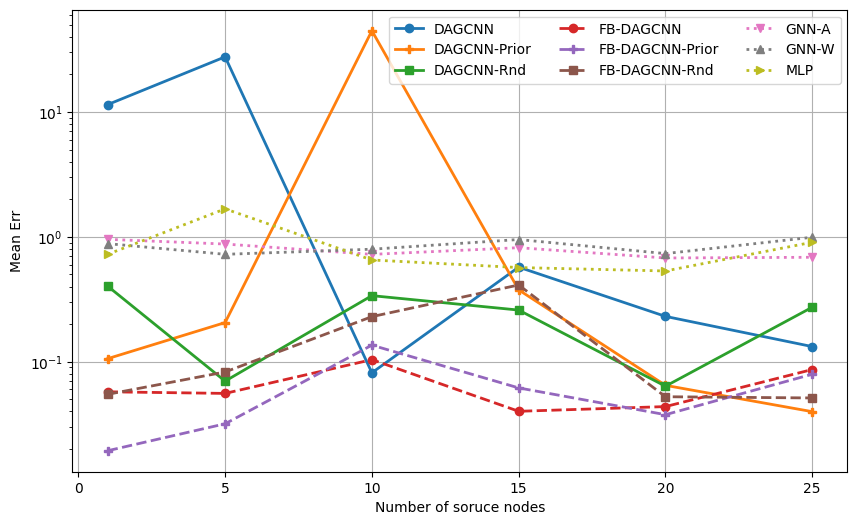

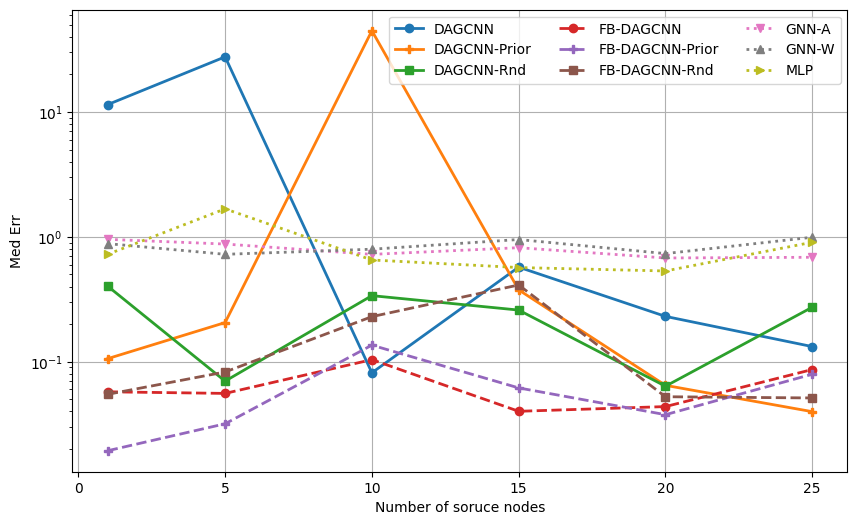

In [ ]:
if SAVE:
    file_name = PATH + f'src_nodes_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_sources)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
med_err = np.median(err, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_err, N_sources, Exps, 'Number of soruce nodes')
utils.plot_results(med_err, N_sources, Exps, 'Number of soruce nodes', ylabel='Med Err')

## Number of randomly selected GSOs

In [ ]:
def influence_selected_gsp_exp(d_dat_p, d_arc_p, d_mod_p, N_GSOs, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Realization:', i)

        Adj, W, GSOs = get_graph_data(d_dat_p)

        for j, n_gsos in enumerate(N_GSOs):
            arch_params_aux = dict(d_arc_p)
            arch_params_aux['n_gsos'] = n_gsos

            err[i,j], std[i,j], times[i,j] = run_exps(exps, arch_params_aux, d_mod_p, d_dat_p, GSOs, W,
                                                      Adj, exp_desc=str(n_gsos))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return err, std, times

In [ ]:
M = 2000
N_GSOs = [5, 10, 15, 20, 25, 30, 45, 50]

Exps = [
    {'arc_p': {'arch': DAGConv, 'GSO': 'GSOs'}, 'leg': 'DAGCNN', 'fmt': 'o-'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'sel_GSOs'}, 'leg': 'DAGCNN-Prior', 'fmt': 'P-'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs'}, 'leg': 'DAGCNN-Rnd', 'fmt': 's-'},


    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'FB-DAGCNN', 'fmt': 'o--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs'}, 'leg': 'FB-DAGCNN-Prior', 'fmt': 'P--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'first_GSOs'}, 'leg': 'FB-DAGCNN-first', 'fmt': 'v--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'last_GSOs'}, 'leg': 'FB-DAGCNN-last', 'fmt': '^--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs'}, 'leg': 'FB-DAGCNN-Rnd', 'fmt': 's--'},
]

err, std, times = influence_selected_gsp_exp(data_p, default_arch_p, default_mod_p, N_GSOs, Exps)


Realization: 0


	-5. DAGCNN: err: 0.070 - time: 0.5
	-5. DAGCNN-Prior: err: 30.200 - time: 0.1
	-5. DAGCNN-Rnd: err: 0.083 - time: 0.1
	-5. FB-DAGCNN: err: 0.106 - time: 0.4
	-5. FB-DAGCNN-Prior: err: 0.033 - time: 0.1
	-5. FB-DAGCNN-first: err: 0.931 - time: 0.1
	-5. FB-DAGCNN-last: err: 0.067 - time: 0.1
	-5. FB-DAGCNN-Rnd: err: 0.509 - time: 0.1
	-10. DAGCNN: err: 1.206 - time: 0.5
	-10. DAGCNN-Prior: err: 19.612 - time: 0.1
	-10. DAGCNN-Rnd: err: 0.063 - time: 0.1
	-10. FB-DAGCNN: err: 0.064 - time: 0.4
	-10. FB-DAGCNN-Prior: err: 0.024 - time: 0.1
	-10. FB-DAGCNN-first: err: 0.516 - time: 0.1
	-10. FB-DAGCNN-last: err: 0.098 - time: 0.1
	-10. FB-DAGCNN-Rnd: err: 0.049 - time: 0.1
	-15. DAGCNN: err: 18.519 - time: 0.5
	-15. DAGCNN-Prior: err: 0.065 - time: 0.1
	-15. DAGCNN-Rnd: err: 0.088 - time: 0.1
	-15. FB-DAGCNN: err: 0.068 - time: 0.4
	-15. FB-DAGCNN-Prior: err: 0.033 - time: 0.1
	-15. FB-DAGCNN-first: err: 0.338 - time: 0.1
	-15. FB-DAGCNN-last: err: 0.083 - time: 0.1
	-15. FB-DAGCNN-Rnd: er

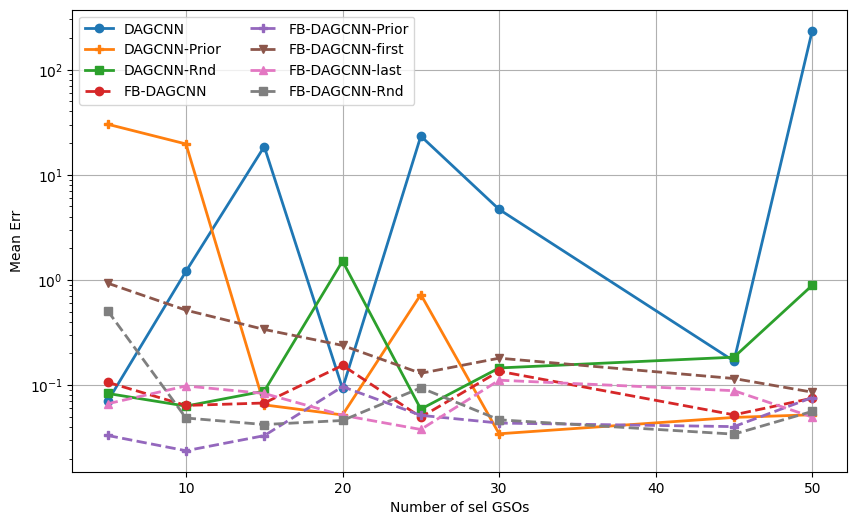

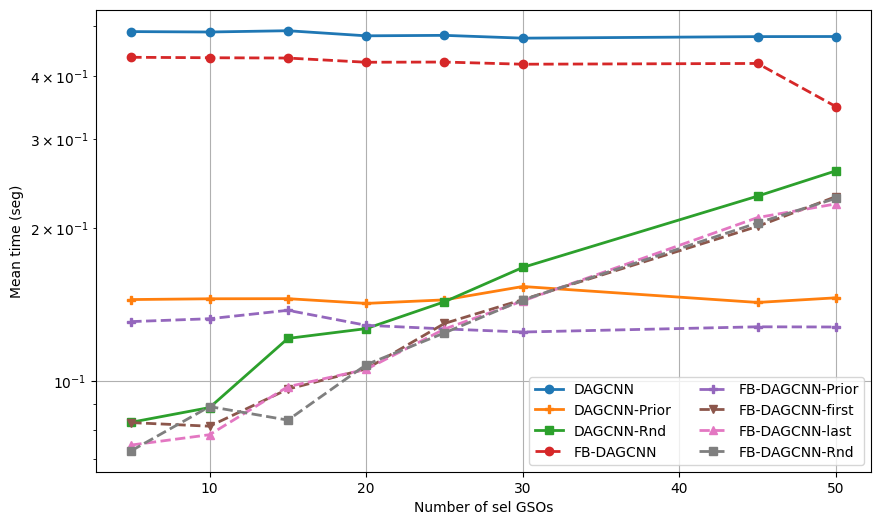

In [ ]:
if SAVE:
    file_name = PATH + f'sel_gso_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_GSOs)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
mean_time = times.mean(axis=0)
med_err = np.median(err, axis=0)
med_time = np.median(times, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(med_err, N_GSOs, Exps, 'Number of sel GSOs', n_cols=2)
utils.plot_results(med_time, N_GSOs, Exps, 'Number of sel GSOs', ylabel='Mean time (seg)', n_cols=2)

## Influence of number of Layers

In [5]:
def influence_n_layers_exp(d_dat_p, d_arc_p, d_mod_p, N_layers, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_layers), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_layers), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_layers), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Realization:', i)

        Adj, W, GSOs = get_graph_data(d_dat_p)

        for j, n_layers in enumerate(N_layers):
            arch_params_aux = dict(d_arc_p)
            arch_params_aux['L'] = n_layers

            err[i,j], std[i,j], times[i,j] = run_exps(exps, arch_params_aux, d_mod_p, d_dat_p, GSOs, W,
                                                      Adj, exp_desc=str(n_layers))

            err[i,j][err[i,j] > 1] = 1

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')

    return err, std, times

In [6]:
M = 2000
N_layers = np.arange(1,7)

Exps = [
    {'arc_p': {'arch': DAGConv, 'GSO': 'GSOs'}, 'leg': 'DAGCNN', 'fmt': 'o-'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'sel_GSOs'}, 'leg': 'DAGCNN-Prior', 'fmt': 'P-'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 25}, 'leg': 'DAGCNN-Rnd',
     'fmt': 's-'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'DAGCNN-Rnd',
     'fmt': 'x-'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'FB-DAGCNN', 'fmt': 'o--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs'}, 'leg': 'FB-DAGCNN-Prior', 'fmt': 'P--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 25}, 'leg': 'FB-DAGCNN-Rnd',
     'fmt': 's--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'FB-DAGCNN-Rnd',
     'fmt': 'x--'}, 

    {'arc_p': {'arch': SF_DAGConv, 'GSO': 'GSOs'}, 'leg': 'SF-DAGCNN', 'fmt': '<:'},


    {'arc_p': {'arch': GCNN, 'GSO': 'A'}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': GCNN, 'GSO': 'W'}, 'leg': 'GNN-W',  'fmt': '^:'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'leg': 'MLP',  'fmt': '>:'},
]

err, std, times = influence_n_layers_exp(data_p, default_arch_p, default_mod_p, N_layers, Exps)


Realization: 0
<function relu at 0x7f595293d750>
	-1. DAGCNN: err: 0.612 - time: 1.0
<function relu at 0x7f595293d750>
	-1. DAGCNN-Prior: err: 7.929 - time: 0.1
<function relu at 0x7f595293d750>
	-1. DAGCNN-Rnd: err: 13.620 - time: 0.1
<function relu at 0x7f595293d750>
	-1. FB-DAGCNN: err: 0.241 - time: 0.1
<function relu at 0x7f595293d750>
	-1. FB-DAGCNN-Prior: err: 2.167 - time: 0.1
<function relu at 0x7f595293d750>
	-1. FB-DAGCNN-Rnd: err: 2.332 - time: 0.1
<function relu at 0x7f595293d750>
	-1. SF-DAGCNN: err: 13564.523 - time: 0.1
<function relu at 0x7f595293d750>
	-1. GNN-A: err: 0.834 - time: 0.9
<function relu at 0x7f595293d750>
	-1. GNN-W: err: 0.827 - time: 0.4
<function relu at 0x7f595293d750>
	-1. MLP: err: 3.039 - time: 0.1
<function relu at 0x7f595293d750>
	-2. DAGCNN: err: 0.234 - time: 0.5
<function relu at 0x7f595293d750>
	-2. DAGCNN-Prior: err: 0.084 - time: 0.1
<function relu at 0x7f595293d750>
	-2. DAGCNN-Rnd: err: 0.174 - time: 0.1
<function relu at 0x7f595293d750>

/home/srey/Investigacion/dag_conv_nn/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/srey/Investigacion/dag_conv_nn/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


	-5. SF-DAGCNN: err: 51273569718543319040.000 - time: 0.7
<function relu at 0x7f595293d750>
	-5. GNN-A: err: 0.782 - time: 2.2
<function relu at 0x7f595293d750>
	-5. GNN-W: err: 0.815 - time: 1.9
<function relu at 0x7f595293d750>
	-5. MLP: err: 0.466 - time: 0.1
<function relu at 0x7f595293d750>
	-6. DAGCNN: err: 48296.395 - time: 1.8
<function relu at 0x7f595293d750>
	-6. DAGCNN-Prior: err: 82.578 - time: 0.5
<function relu at 0x7f595293d750>
	-6. DAGCNN-Rnd: err: 8.445 - time: 0.4
<function relu at 0x7f595293d750>
	-6. FB-DAGCNN: err: 0.049 - time: 2.0
<function relu at 0x7f595293d750>
	-6. FB-DAGCNN-Prior: err: 0.059 - time: 0.6
<function relu at 0x7f595293d750>
	-6. FB-DAGCNN-Rnd: err: 0.055 - time: 0.5
<function relu at 0x7f595293d750>
	-6. SF-DAGCNN: err: 571135371844847442853888.000 - time: 0.6
<function relu at 0x7f595293d750>
	-6. GNN-A: err: 0.843 - time: 0.5
<function relu at 0x7f595293d750>
	-6. GNN-W: err: 0.793 - time: 0.5
<function relu at 0x7f595293d750>
	-6. MLP: err: 

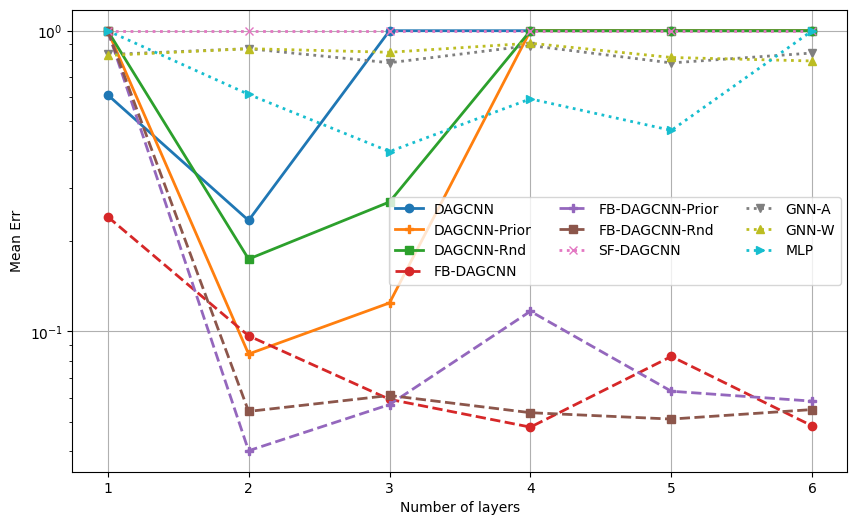

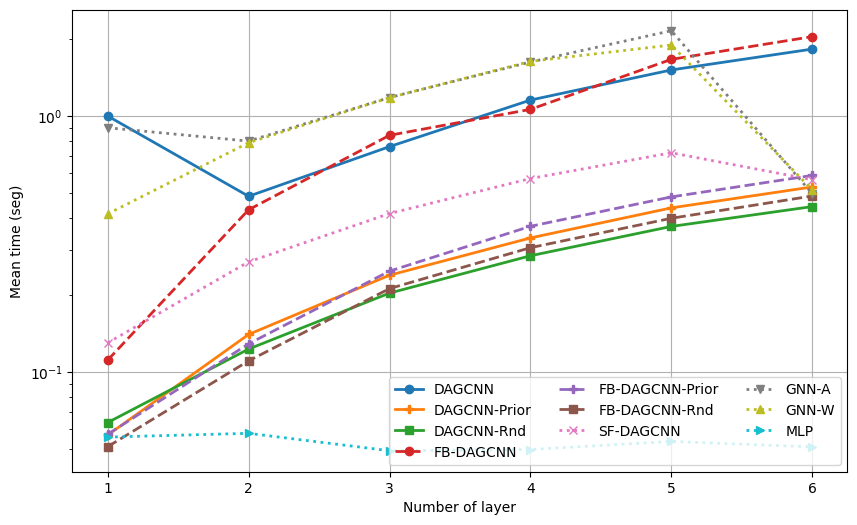

In [7]:
if SAVE:
    file_name = PATH + f'n_layers_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_layers)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
mean_time = times.mean(axis=0)
med_err = np.median(err, axis=0)
legend = [exp['leg'] for exp in Exps]
skip_idx = [8, 9, 10, 11]
utils.plot_results(mean_err, N_layers, Exps, 'Number of layers', skip_idx=skip_idx)
utils.plot_results(mean_time, N_layers, Exps, 'Number of layer', ylabel='Mean time (seg)',
                   skip_idx=skip_idx)

skip_idx = [0, 1, 2, 3]
utils.plot_results(mean_err, N_layers, Exps, 'Number of layers', skip_idx=skip_idx)
utils.plot_results(mean_time, N_layers, Exps, 'Number of layer', ylabel='Mean time (seg)',
                   skip_idx=skip_idx)